In [1]:
# import matplotlib.pyplot as plt
# from PIL import Image
import glob
import os
import sys

# CustomDataset should return:
# image: a PIL Image of size (H, W)
# target: a dict containing the following fields
# flow (FloatTensor[N, 4]): the .flo file containing 

class CustomDataset():
  def __init__(self, root):
    self.frames_dir = os.path.join('data', root, "**/*.png")
    print(self.frames_dir)
    
    self.all_frames = []
    for filename in glob.iglob(self.frames_dir, recursive = True):
        self.all_frames.append(filename)

  def __len__(self):
    return len(self.all_frames)

  def __getitem__(self, idx):
    # returns the example at index "idx"
    return self.all_frames[idx]

In [2]:
# replace data_paths and labels with your desired paths and labels
data_paths = ['MPI-Sintel-complete/training/frames/final', 'Middlebury/training/frames']
labels = ['Sintel', 'Middlebury']

datasets = []
for data in data_paths:
    datasets.append(CustomDataset(data))

print(len(datasets[0]))
print(len(datasets[1]))
print(datasets[0][0])

data/MPI-Sintel-complete/training/frames/final/**/*.png
data/Middlebury/training/frames/**/*.png
1064
84
data/MPI-Sintel-complete/training/frames/final/ambush_7/frame_0028.png


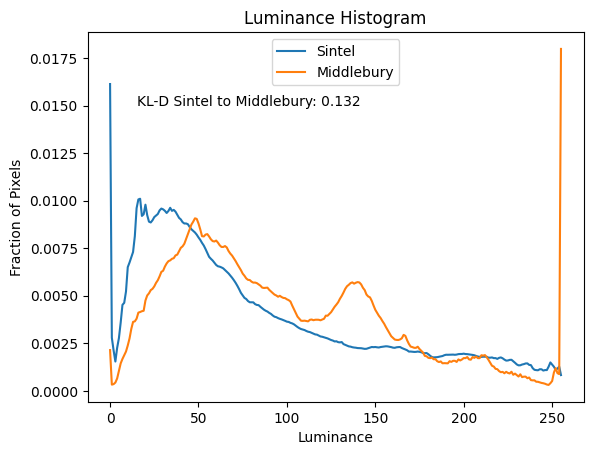

In [3]:
# Luminance
import scipy
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# returns a numpy nd array of 256 numbers, 
# each corresponding to the fraction of pixels in frames of 
# a dataset at a luminance (index)
def get_luminance(dataset):
    total_lum = np.zeros(256)
    for idx in range(len(dataset)):
        img = Image.open(dataset[idx]).convert('L')
        total_lum += np.array(img.histogram())
    fractional_lum = total_lum / np.sum(total_lum)
    return fractional_lum
    
def plot_luminance(datasets, labels):
    lums = []
    for i in range(len(datasets)): 
        fractional_lum = get_luminance(datasets[i])
        lums.append(fractional_lum)
        plt.plot(fractional_lum, label=labels[i])
    # KL Divergence with e as log base
    kl = scipy.stats.entropy(lums[0], lums[1])
    s = "KL-D {} to {}: {:.3f}".format(labels[0], labels[1], kl)
    plt.text(15, 0.0150, s)
    plt.title("Luminance Histogram")
    plt.xlabel("Luminance")
    plt.ylabel("Fraction of Pixels")
    plt.legend()
    
plot_luminance(datasets, labels)

In [ ]:
# Spatial Power Spectra
import math

# center crop is of size 436 x 436 (change as necessary for your dataset)
cropx, cropy = 436, 436
total_pix = cropx * cropy
def crop_center(img,cropx,cropy):
    y,x = img.shape
    startx = x//2-(cropx//2)
    starty = y//2-(cropy//2)    
    return img[starty:starty+cropy,startx:startx+cropx]

def get_spatial_power_spectra(dataset):
    running_ps = np.empty(cropx * cropy)
    for frame in range(len(dataset)):
        print(frame)
        img = Image.open(dataset[frame]).convert("L")
        img = np.asarray(img)
        cropped_img = np.copy(crop_center(img, cropx, cropy))

        # calculate weights of Kaiser-bessel window
        rmax = 218
        w = np.empty(cropped_img.shape)
        windowed_img = np.empty(cropped_img.shape)
        for x in range(cropped_img.shape[1]):
            for y in range(cropped_img.shape[0]):
                r = ((x - 218)**2 + (y - 218)**2)**0.5
                if r < rmax:
                    w_r = 0.54 - 0.46*math.cos(math.pi*(1 - r/rmax))
                    windowed_img[x][y] = w_r * cropped_img[x][y]
                else:
                    w_r = 0
                    windowed_img[x][y] = 0

                w[x][y] = w_r

        # to avoid leakage in spectral transformation, we subtract the 
        # weighted mean intensity (normalizing_factor) before applying
        # the KB window
        normalizing_factor = np.sum(np.multiply(cropped_img, w)) / (np.sum(w))
        normalized_img = (cropped_img - normalizing_factor) / normalizing_factor

        # Fourier transform to get power spectrum
        # used this paper to calculate: 
        # van der Schaaf, A., van Hateren, J.: Modelling the power spectra of natural images: Statistics and
        # information. Vision Research 36 (1996) 2759 – 2770
        f = np.abs(np.fft.fft2(windowed_img))
        ps = np.square(f)
        ps = ps.flatten()
        running_ps += ps

    freqs = np.fft.fftfreq(ps.shape[0]) * ps.shape[0] # in x-direction
    freqs2d = np.meshgrid(freqs, freqs)
    freqs2d = np.sqrt(freqs2d[0]**2 + freqs2d[1]**2)
    freqs2d = freqs2d.flatten()
    avg_ps = running_ps / total_pix
    return freqs2d, avgps

def plot_spatial_power_spectra(datasets, labels):
    for dataset in datasets:
        freqs2d, avgps = get_spatial_power_spectra(dataset)

        plt.plot(freqs2d, avg_ps)
        
plot_spatial_power_spectra(datasets, labels)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45


In [ ]:
# Spatial Derivative
import collections

# plots spatial derivative of dataset
def get_spatial_derivatives(dataset):
    # min difference can be (0 - 255) and max difference can be (255 - 0)
    total_differences = collections.Counter()
    for idx in range(len(dataset)):
        img = np.asarray(Image.open(dataset[idx]).convert('L'), dtype='int32')
        diff = np.reshape(np.diff(img), -1)
        diff_counter = collections.Counter(diff)
        total_differences.update(diff_counter)   
        
    totalPixelCount = sum(total_differences.values())
    for item in total_differences: 
        total_differences[item] /= totalPixelCount
        
    k = scipy.stats.kurtosis(list(total_differences.values())) 
        
    return total_differences, k

def plot_spatial_derivatives(datasets, labels):
    for i in range(len(datasets)): 
        total_differences, k = get_spatial_derivatives(datasets[i])
        s = '{} Kurtosis = {:.2f}'.format(labels[i], k)
        plt.text(-80, -18 - 1.5*i, s)
        
        # take log for better visualization
        for item in total_differences:
            total_differences[item] = math.log(total_differences[item])
        plt.plot(*zip(*sorted(total_differences.items())), label=labels[i])
        
    plt.title("Spatial Derivative")
    plt.xlabel("dI/dx")
    plt.ylabel("log(fraction of pixels)")
    plt.legend()

plot_spatial_derivatives(datasets, labels)